In [42]:
import os
import dill as pickle
import ztffields
import numpy as np
import matplotlib.pyplot as plt

from concurrent.futures import ProcessPoolExecutor, as_completed
from astropy.io import fits, ascii

try:
    from Tile import Tile
    from utils import get_data_path
except ModuleNotFoundError:
    from Extracting.Tile import Tile
    from Extracting.utils import get_data_path

In [43]:
# Load the field geometries
fields = ztffields.Fields()  # TODO: Some filter on fields
field_info, field_polygons = fields.get_field_vertices([1557, 1558], level='quadrant', steps=2)

In [44]:
data_path = get_data_path()
quadrant = field_polygons[0][0]

# Get the center of the quadrant
ra_center, dec_center = np.mean(quadrant[:, 0]), np.mean(quadrant[:, 1])

# Make a tile, run extraction, and store the catalogs
tile = Tile(
    ra_center,
    dec_center,
    bands=['i'],
    data_dir=os.path.join(data_path, 'ztf_data'),
    parallel=False
)

Querying metadata from https://irsa.ipac.caltech.edu/ibe/search/ztf/products/deep?WHERE=ra>89.80769428070157+AND+ra<90.69658318070158+AND+dec>12.446347031680897+AND+dec<13.335235931680899+AND+filtercode='zi'
Image already downloaded and saved at /Users/adamboesky/Research/long_transients/Data/ztf_data/ztf_000512_zi_c12_q1_refimg.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


In [6]:
tile_output_path = tile.store_catalogs(os.path.join(data_path, 'local_catalog_results'), overwrite=True)

In [22]:
from astropy.io import ascii
test = ascii.read('/Users/adamboesky/Research/long_transients/Data/local_catalog_results/000512_12_1/PSTARR.ecsv')
i_assoc = ascii.read('/Users/adamboesky/Research/long_transients/Data/local_catalog_results/000512_12_1/i_associated.ecsv')

In [17]:
from Extracting.Catalogs import PSTARR_Catalog
ps = PSTARR_Catalog(tile.ra_range, tile.dec_range, prefetch=True)
t = PSTARR_Catalog((0,0.25), (30, 30.25))
tab = t.get_data()
mask = (tab['gPSFMag'] > 0) & (tab['gKronMag'] > 0)

(-2.0, 5.0)

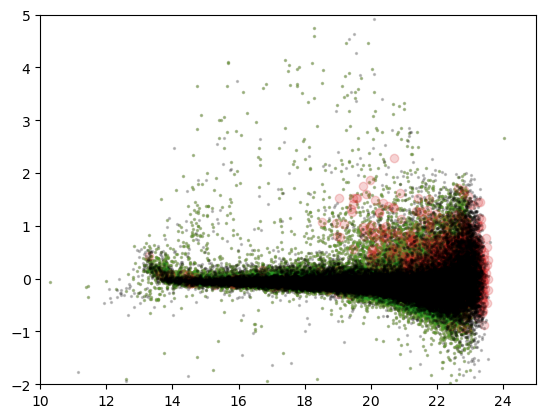

In [29]:
plt.scatter(test['iPSFMag'], test['iPSFMag'] - test['iKronMag'], s=2, alpha=0.2)
plt.scatter(tile.pstar_catalog.data['iPSFMag'], tile.pstar_catalog.data['iPSFMag'] - tile.pstar_catalog.data['iKronMag'], s=2, alpha=0.2)
plt.scatter(ps.data['iPSFMag'], ps.data['iPSFMag'] - ps.data['iKronMag'], s=2, alpha=0.2)
plt.scatter(tab['gPSFMag'][mask], tab['gPSFMag'][mask] - tab['gKronMag'][mask], alpha=0.2)
plt.scatter(i_assoc['PSTARR_gPSFMag'], i_assoc['PSTARR_gPSFMag'] - i_assoc['PSTARR_gKronMag'], s=2, alpha=0.2, color='k')
plt.xlim((10, 25))
plt.ylim((-2, 5))

(10.0, 27.0)

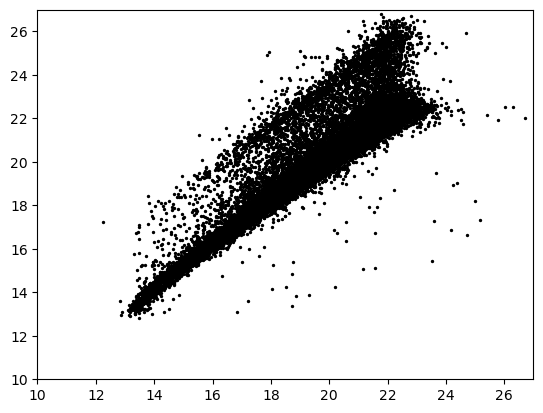

In [35]:
plt.scatter(i_assoc['PSTARR_iPSFMag'], i_assoc['ZTF_iPSFMag'], s=2, color='k')
plt.xlim((10, 27))
plt.ylim((10, 27))

In [38]:
residual_image = tile.ztf_catalogs['i'].sextractors['i'].psfphot.make_residual_image(tile.ztf_catalogs['i'].sextractors['i'].image_sub, (9, 9))

# Create a new FITS file with the residual image data
hdu = fits.PrimaryHDU(residual_image)
hdul = fits.HDUList([hdu])

# Save the FITS file
output_path = 'residual_image.fits'
hdul.writeto(output_path, overwrite=True)

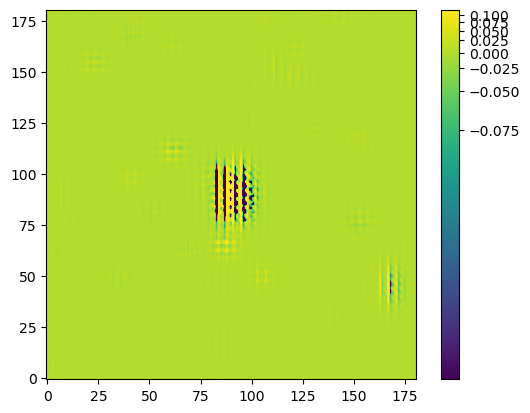

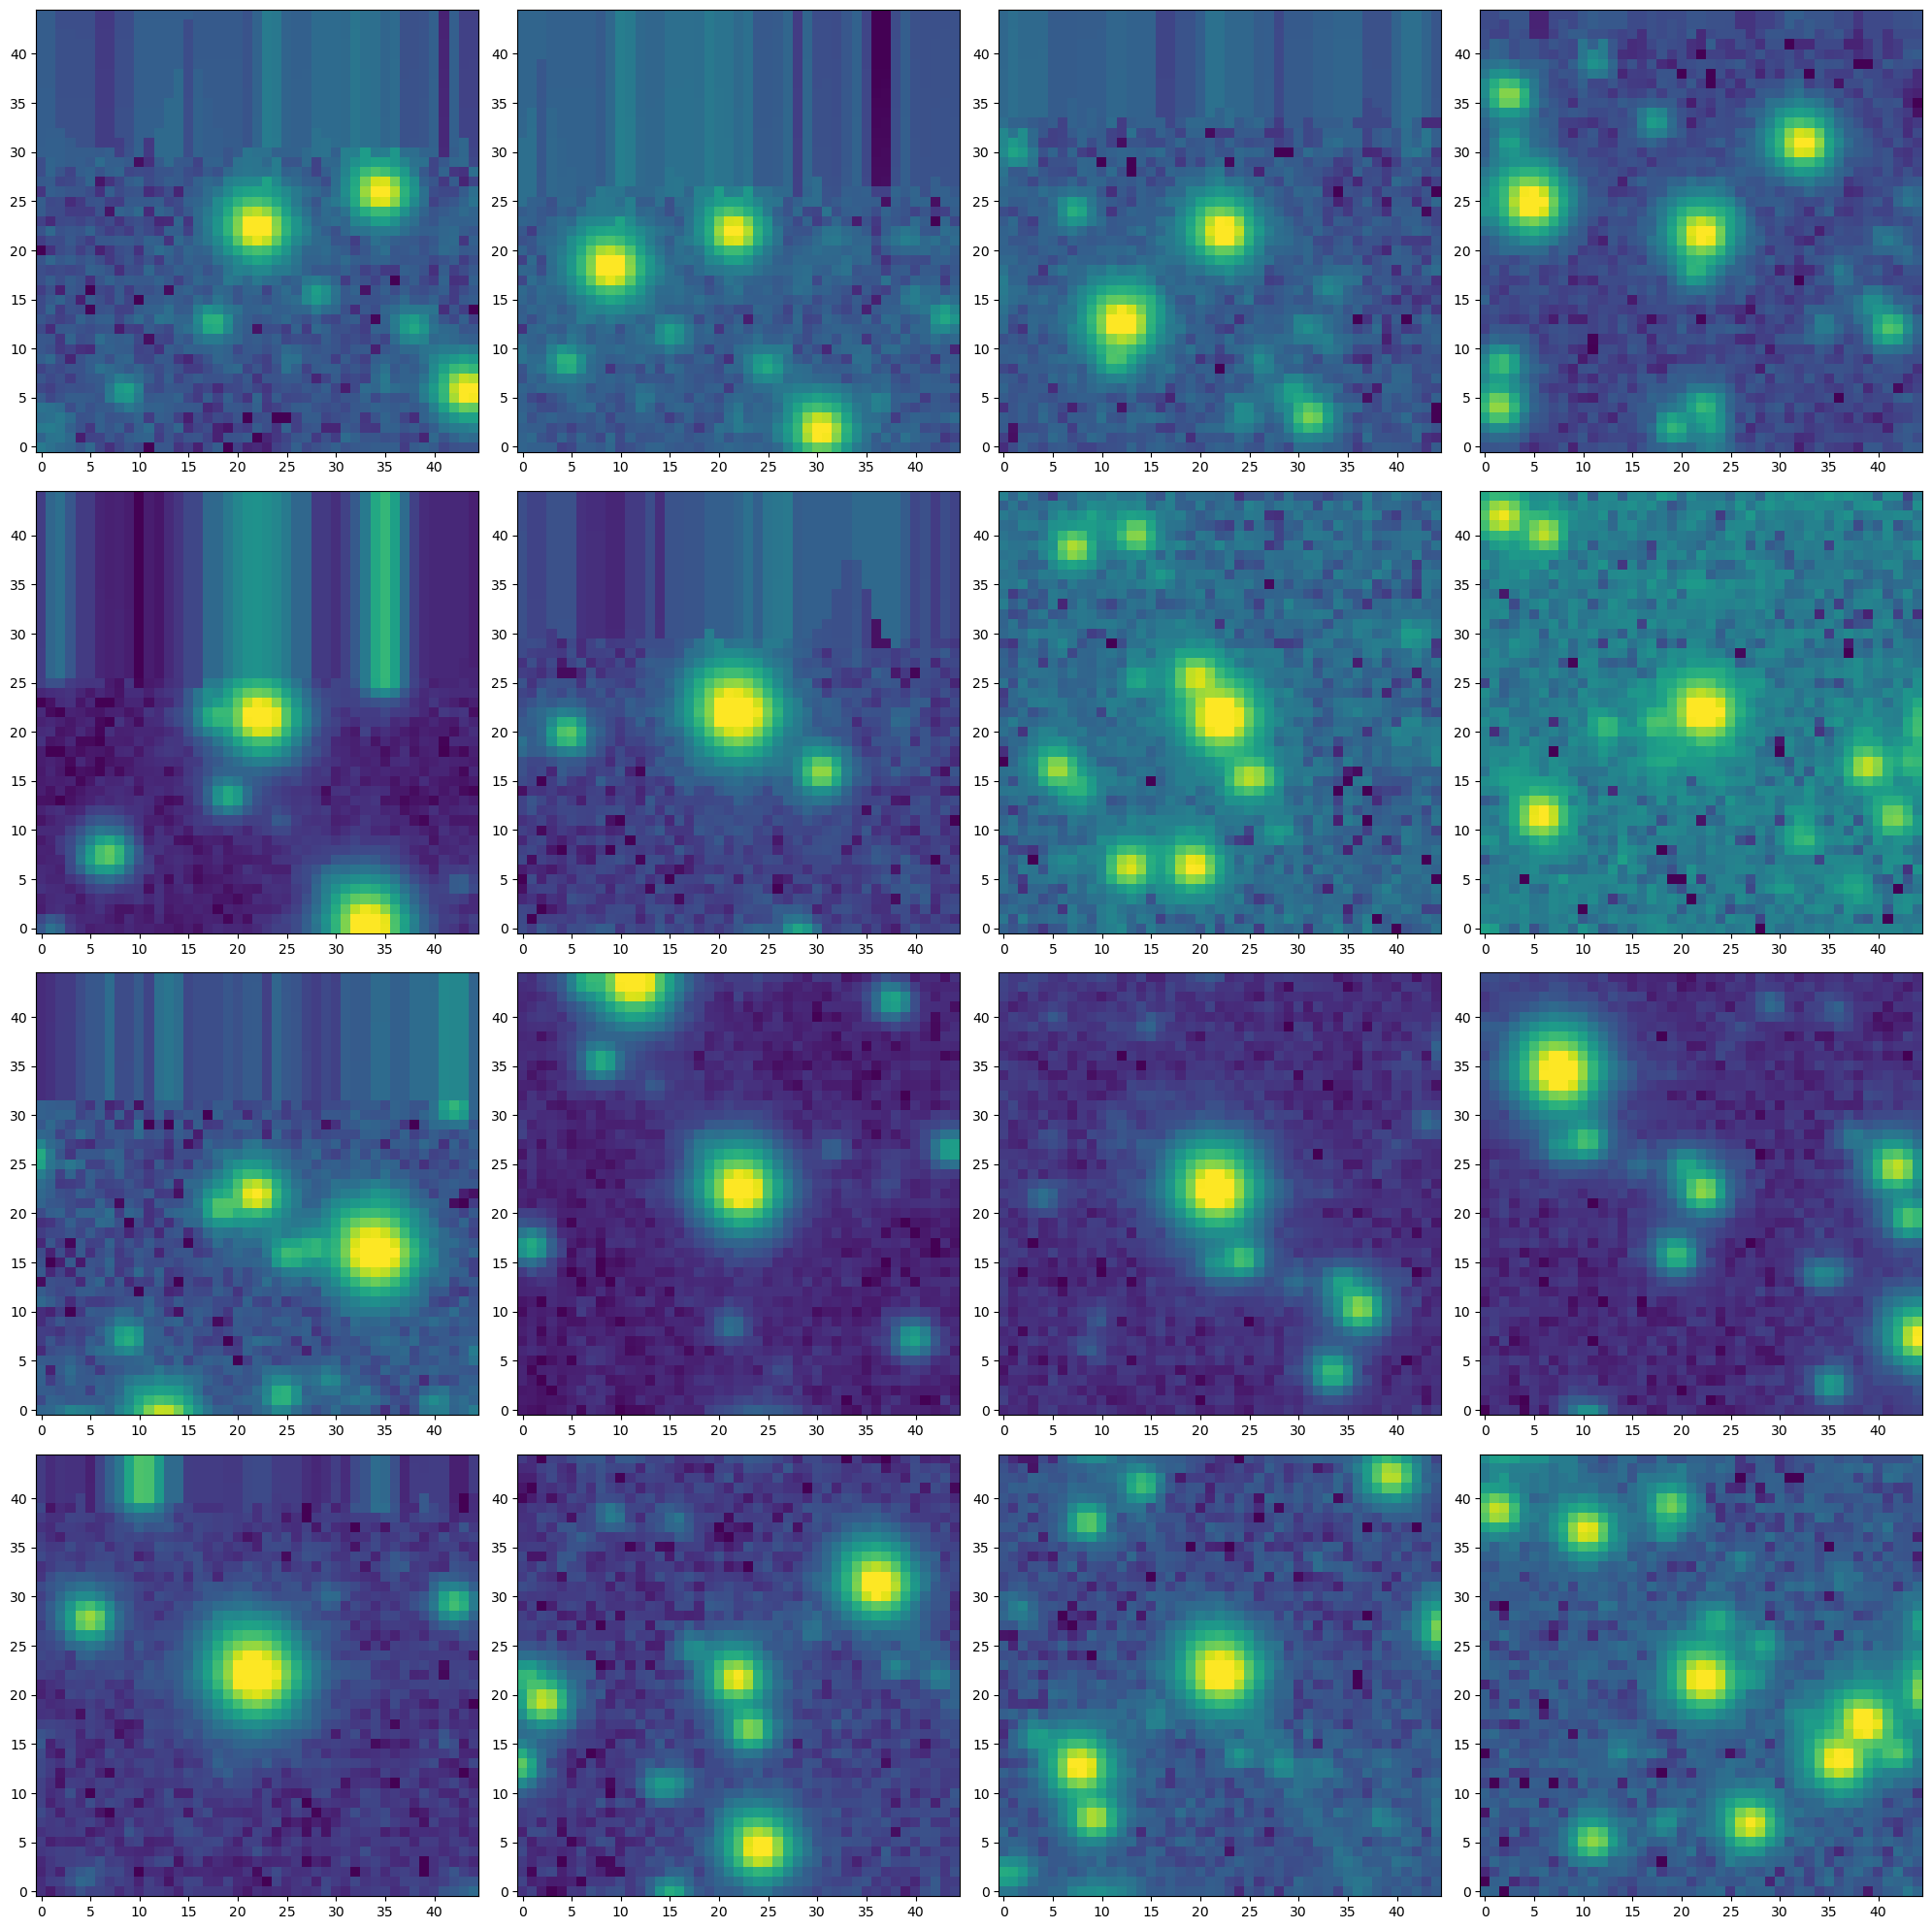

In [41]:
from astropy.visualization import simple_norm
norm = simple_norm(tile.ztf_catalogs['i'].sextractors['i'].epsf.data, 'log', percent=99.0)
plt.imshow(tile.ztf_catalogs['i'].sextractors['i'].epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
for i, ax in enumerate(axes.flatten()):
    norm = simple_norm(tile.ztf_catalogs['i'].sextractors['i'].stars.all_good_stars[i], 'log', percent=99.0)
    ax.imshow(tile.ztf_catalogs['i'].sextractors['i'].stars.all_good_stars[i], norm=norm, origin='lower', cmap='viridis')
plt.tight_layout()
plt.show()

In [3]:
data_path = get_data_path()
for quadrant in field_polygons[0]:
    # Get the center of the quadrant
    ra_center, dec_center = np.mean(quadrant[:, 0]), np.mean(quadrant[:, 1])

    # Make a tile, run extraction, and store the catalogs
    tile = Tile(
        ra_center,
        dec_center,
        bands=['i'],
        data_dir=os.path.join(data_path, 'ztf_data'),
        parallel=False
    )
    tile_output_path = tile.store_catalogs(os.path.join(data_path, 'local_catalog_results'), overwrite=True)

    # For testing, store the tile objects as well (NOTE: DELTE THIS IN THE FUTURE)
    with open(os.path.join(tile_output_path, 'tile.pkl'), 'wb') as f:
        pickle.dump(tile, f)

Querying metadata from https://irsa.ipac.caltech.edu/ibe/search/ztf/products/deep?WHERE=ra>89.80769428070157+AND+ra<90.69658318070158+AND+dec>12.446347031680897+AND+dec<13.335235931680899+AND+filtercode='zi'
Image already downloaded and saved at /Users/adamboesky/Research/long_transients/Data/ztf_data/ztf_000512_zi_c12_q1_refimg.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:27: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)


Calculating PSF magnitudes...
Fitting PSF model using 3935 stars...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:27: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


OSError: File /Users/adamboesky/Research/long_transients/Data/local_catalog_results/000512_12_1/PSTARR.ecsv already exists. If you mean to replace it then use the argument "overwrite=True".

In [3]:
from astropy.io import ascii
test = ascii.read('/Users/adamboesky/Research/long_transients/Data/local_catalog_results/field_results/000512_i.ecsv')

In [15]:
from typing import Optional

def img_ab_mag_to_flux(mag: np.ndarray, zero_point: np.ndarray, magerr: Optional[np.ndarray] = None) -> np.ndarray:
    """Inverse of img_flux_to_ab_mag."""
    flux = 10 ** ((mag - zero_point) / -2.5)
    if magerr is not None:
        fluxerr = (magerr * (np.log(10) * flux)) / 2.5
        return flux, fluxerr
    return flux

def get_snr_from_mag(mag, magerr, zp):
        flux, fluxerr = img_ab_mag_to_flux(mag, zero_point=zp, magerr=magerr)
        return flux / fluxerr

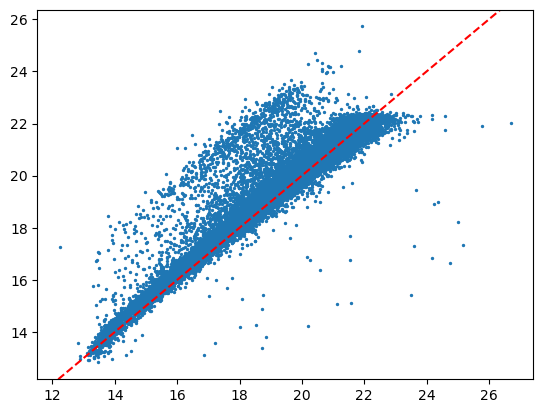

In [17]:
import matplotlib.pyplot as plt

snr = get_snr_from_mag(test['ZTF_iPSFMag'], test['ZTF_iPSFMagErr'], 25.0)
mask = (test['ZTF_iPSFMag'] != -999) & (test['PSTARR_iPSFMag'] != -999) & (test['Catalog_Flag'] == 0) & (snr > 5)
plt.scatter(test['PSTARR_iPSFMag'][mask], test['ZTF_iPSFMag'][mask], s=2)
plt.axline((15, 15), slope=1, color='red', linestyle='--')
plt.show()

In [ ]:
from astropy.io import fits
residual_image = tile.ztf_catalogs['g'].sextractors['g'].psfphot.make_residual_image(tile.ztf_catalogs['g'].sextractors['g'].image_sub, (9, 9))

# Create a new FITS file with the residual image data
hdu = fits.PrimaryHDU(residual_image)
hdul = fits.HDUList([hdu])

# Save the FITS file
output_path = 'residual_image.fits'
hdul.writeto(output_path, overwrite=True)

print(f"Residual image saved to {output_path}\nOriginal image saved to {tile.ztf_catalogs['g'].sextractors['g'].fits_fpath}")

# Save the point source coordinates to a text file
with open('residual_pointsources.txt', 'w') as f:
    for ra, dec in zip(tile.ztf_catalogs['g'].sextractors['g']._point_source_coords.ra.deg, tile.ztf_catalogs['g'].sextractors['g']._point_source_coords.dec.deg):
        x, y = tile.ztf_catalogs['g'].sextractors['g'].ra_dec_to_pix(ra, dec)
        f.write(f"{x} {y}\n")
print("Point source coordinates saved to residual_pointsources.txt")

tile.ztf_catalogs['g'].sextractors['g'].store_coords(fpath='resid_objs.txt', coord_system='pixel')
print('All objects saved to resid_objs.txt')

In [21]:
from astropy.nddata import NDData
from astropy.table import Table
from photutils.psf import IntegratedGaussianPRF, PSFPhotometry, EPSFBuilder, EPSFFitter, extract_stars
self = tile.ztf_catalogs['i'].sextractors['i']
data_for_fit = NDData(data=self.image_sub, wcs=self.wcs)
stars = extract_stars(data_for_fit, Table([self._point_source_coords], names=['skycoord']), size=45)
fitter = EPSFFitter(fit_boxsize=13)
epsf_builder = EPSFBuilder(fitter=fitter)  # TODO: try oversampling, and fitter box size         oversampling=4, 
self.epsf, fitted_stars = epsf_builder(stars)

KeyboardInterrupt: 

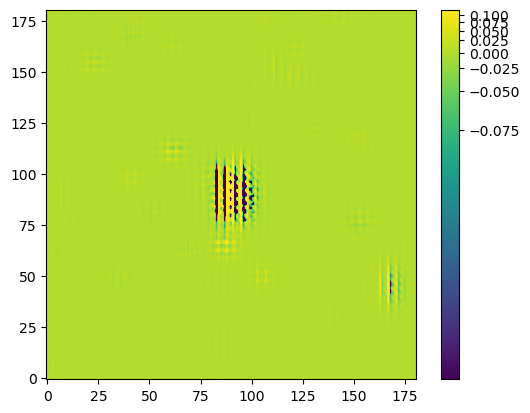

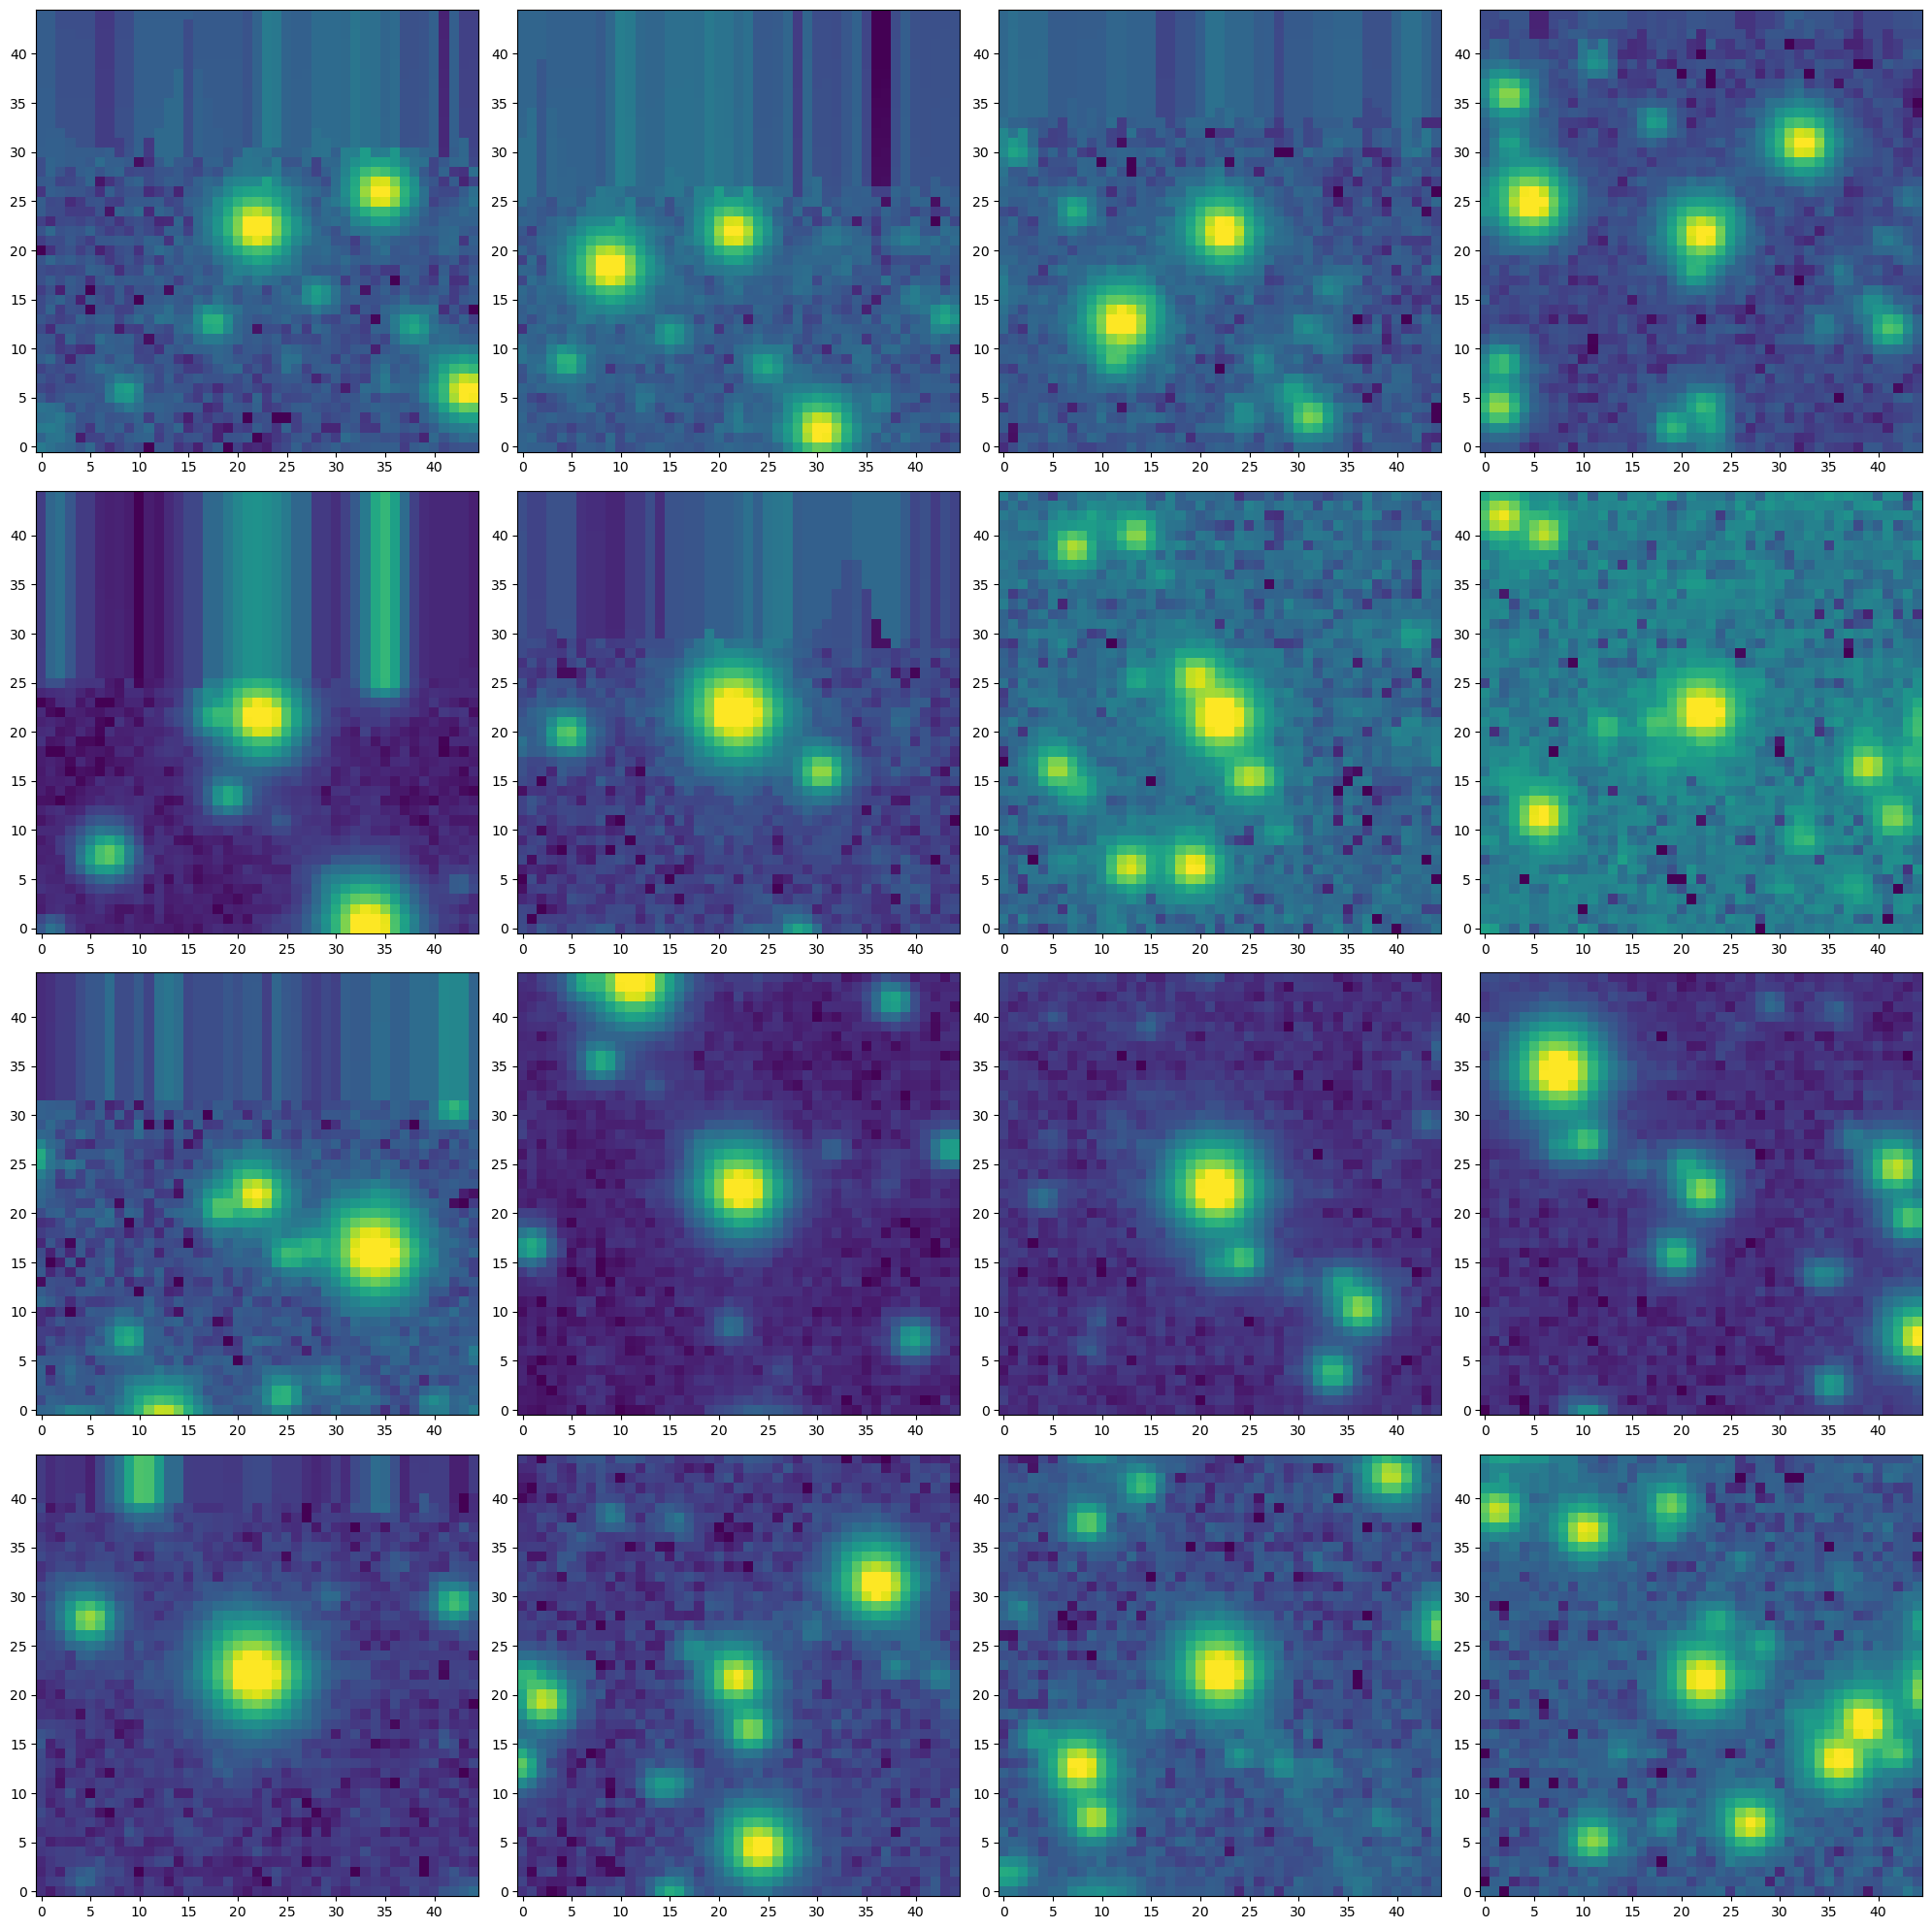

In [22]:
from astropy.visualization import simple_norm
norm = simple_norm(self.epsf.data, 'log', percent=99.0)
plt.imshow(self.epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
for i, ax in enumerate(axes.flatten()):
    norm = simple_norm(stars.all_good_stars[i], 'log', percent=99.0)
    ax.imshow(stars.all_good_stars[i], norm=norm, origin='lower', cmap='viridis')
plt.tight_layout()
plt.show()

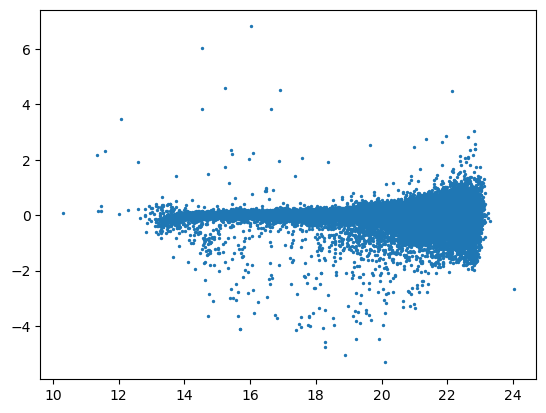

In [5]:
import matplotlib.pyplot as plt
mask = (test['PSTARR_iPSFMag'] != -999) & (test['PSTARR_iKronMag'] != -999)
plt.scatter(test['PSTARR_iPSFMag'][mask], (test['PSTARR_iKronMag'] - test['PSTARR_iPSFMag'])[mask], s=2)

In [6]:
tile.pstarr_catalogs['i']

NameError: name 'tile' is not defined